## 2.1 Source

### 2.1.1 Connecting to the database 

This project uses a structured SQLite database (org_compliance_data.db) as its primary data source.
The database contains multiple tables describing departmental characteristics, compliance-related metrics, and reference information.

We establish a connection to the database and inspect its structure to understand the available tables and their roles within the project.

In [98]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#connect to the SQLite database
db = sqlite3.connect('data/org_compliance_data.db')

# Query to get the list of tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", db)


### 2.1.2 Inspecting the Database Structure

Before selecting the dataset for analysis, we examine all available tables in the database.
This step helps identify which tables are suitable for modeling, which serve as references, and which provide contextual or auxiliary information.

For each table, a small preview is displayed to understand its schema and content.

In [99]:
#available tables in the database
print(tables)

#first rows of the each table
for name in tables["name"]:
    print(f"table: {name}")
    preview = pd.read_sql(f"SELECT * FROM {name} LIMIT 5;", db)
    print(preview)
    

                       name
0               departments
1  risk_summary_by_division
2     high_risk_departments
3           data_dictionary
table: departments
     dept_id                   dept_name           dept_category  \
0  DEPT-1620             Core Compliance     Financial_Reporting   
1  DEPT-1133          Digital Governance     Financial_Reporting   
2  DEPT-4917                 Central Hub  Operational_Compliance   
3  DEPT-6959  Compliance - Legacy Region     Financial_Reporting   
4  DEPT-4312      West Internal Controls     Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Operations             8.0        Remote     Large   
1  Corporate_HQ  Compliance             8.0         Urban     Large   
2          None        None             NaN          None      None   
3  Corporate_HQ     Support             8.0         Urban     Large   
4  Corporate_HQ  Operations             6.0         Urban     Small   

  rep

### 2.1.3 Loading the Main Department-Level Dataset

The departments table is loaded as the primary analytical dataset.
This table contains department-level operational, reporting, organizational, and risk-related features that form the basis for all subsequent analysis and modeling steps.

We inspect its structure, data types, and summary statistics to ensure that it is suitable for machine learning tasks.

In [100]:
#Loading the departement table / possible main table
departments = pd.read_sql("SELECT * FROM departments", db)
departments.head()

#inspecting the departments table
departments.info()
departments.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          709 non-null    object 
 1   dept_name                        709 non-null    object 
 2   dept_category                    709 non-null    object 
 3   division                         455 non-null    object 
 4   dept_type                        413 non-null    object 
 5   dept_age_years                   411 non-null    float64
 6   location_type                    410 non-null    object 
 7   team_size                        409 non-null    object 
 8   reporting_structure              413 non-null    object 
 9   manager_experience_level         413 non-null    float64
 10  supervisor_experience_level      409 non-null    float64
 11  primary_function                 416 non-null    object 
 12  secondary_function    

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
count,709,709,709,455,413,411.000000,410,409,413,413.000000,...,410.000000,406.000000,416.000000,410.000000,411.000000,412.000000,430.000000,435.000000,433.000000,409.000000
unique,682,454,3,2,6,NaN,4,3,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,DEPT-9694,Tactical Quality Assurance,Financial_Reporting,Corporate_HQ,Support,NaN,Urban,Large,Centralized,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,5,419,428,206,NaN,304,272,332,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,6.802920,NaN,NaN,NaN,2.624697,...,3.190244,3.086207,1.673077,2.360976,3.491484,5.114078,61.707209,62.113333,63.955427,26.783619
std,NaN,NaN,NaN,NaN,NaN,1.915939,NaN,NaN,NaN,1.164637,...,1.061854,1.190479,1.112404,1.361877,1.447218,6.514748,12.927911,13.338300,13.693694,19.144580
min,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,30.000000,0.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,2.000000,...,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,54.125000,54.900000,55.000000,12.000000
50%,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,3.000000,...,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,60.000000,60.000000,65.000000,20.000000
75%,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,4.000000,...,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,70.000000,70.000000,75.000000,34.000000


### 2.1.4 Understanding Feature Definitions

To correctly interpret the variables used in the analysis, we inspect the data_dictionary table.
This table provides definitions, data types, and descriptions for each feature, supporting informed preprocessing decisions such as encoding, scaling, and feature selection.

In [101]:
#inspecting the different dict
dtype_dict = pd.read_sql("SELECT * FROM data_dictionary", db)
dtype_dict.head(20)

,table_name,field_name,data_type,description
0,departments,dept_id,string,Unique department identifier
1,departments,dept_name,string,Department name
2,departments,dept_category,string,Primary compliance category (Financial_Reporti...
3,departments,division,string,"Organizational division (Corporate_HQ, Regiona..."
4,departments,dept_type,string,"Department type (Operations, Support, Complian..."
5,departments,dept_age_years,integer,Age of department in years since establishment
6,departments,location_type,string,"Geographic location type (Urban, Remote, Subur..."
7,departments,team_size,string,"Team size category (Small, Medium, Large)"
8,departments,reporting_structure,string,"Reporting hierarchy (Centralized, Autonomous, ..."
9,departments,manager_experience_level,integer,Manager experience level (0=none to 4=extensive)


### Explanation of Database Tables

⸻

departments

This is the main table used in the project and contains comprehensive department-level data, including operational metrics, compliance-related indicators, reporting behavior, managerial experience, training activities, and historical infractions.
It serves as the primary analytical dataset and provides the row-level observations required for modeling compliance risk.

⸻

risk_summary_by_division

This table contains aggregated, division-level risk indicators (e.g., Corporate HQ, Regional Operations).
While it is not used as an input for the machine learning models, it provides useful contextual information that may support descriptive analysis and high-level interpretation of risk patterns across organizational units.

⸻

high_risk_departments

This table lists departments that are classified as high risk based on external criteria or prior evaluations.
It is not used as a source of predictive features, but rather as an external reference to construct the binary target variable (is_high_risk) used in the supervised learning task.

⸻

data_dictionary

The data dictionary provides detailed definitions, data types, and descriptions for all variables in the database.
It supports accurate feature interpretation and informed preprocessing decisions, such as identifying numerical versus categorical variables and determining appropriate handling strategies within the modeling pipeline.

⸻

Main Dataset for Analysis

The departments table serves as the primary dataset for this project, as it includes all department-level features required for compliance-focused machine learning analysis.
Other tables are not directly used for model training but contribute to labeling, interpretation, and contextual understanding of the data.

### 2.2 Data Cleaning

Missing Value Analysis

Before applying any preprocessing steps, we analyze the presence and distribution of missing values across all department-level features.
This analysis allows us to understand whether missingness is systematic or sparse and to select appropriate imputation strategies without discarding valuable observations.

A summary table is created to report both the absolute count and the percentage of missing values per feature.

In [102]:
#analysis of missing value
miss_counts = departments.isnull().sum()
miss_percent = (departments.isnull().mean() * 100).round(2)

#create a table to summarize missing values
miss_table = pd.DataFrame({
    "miss_counts": miss_counts,
    "miss_percent": miss_percent
}).sort_values(by="miss_percent", ascending=False)

miss_table

,miss_counts,miss_percent
digital_systems,304,42.88
external_interactions_frequency,303,42.74
interdept_collaboration_score,303,42.74
oversight_body,303,42.74
violations_past_3years,303,42.74
onboarding_program,302,42.60
overall_risk_score,300,42.31
training_hours_quarterly,300,42.31
team_size,300,42.31
external_partnerships,300,42.31


### 2.2.1 Handling Missing Values

To ensure consistency and preserve all departments in the dataset, missing values are handled as follows:
	•	Numerical features are imputed using the median, which is robust to skewed distributions and outliers.
	•	Categorical features are imputed using the mode, preserving the most frequent category without introducing artificial values.

This approach maintains dataset completeness while minimizing distortion of underlying feature distributions.

In [103]:
#separating numerical and categorical columns
num_col = departments.select_dtypes(include=["float64", "int64"]).columns
categorical_col = departments.select_dtypes(include=["object"]).columns

num_col, categorical_col

#cleaning numberical columns by filling missing values with median
for col in num_col:
    median_value = departments[col].median()
    departments[col] = departments[col].fillna(median_value)

#cleaning categorical columns by filling missing values with mode
for col in categorical_col:
    mode_value = departments[col].mode()[0]
    departments[col] = departments[col].fillna(mode_value)

#check if there are any missing values left
departments.isnull().sum().sum()



0

### 2.3 Outlier analysis
Outliers are identified using the Interquartile Range (IQR) method, where values are flagged if they fall below
Q1 − 1.5 × IQR or above Q3 + 1.5 × IQR.

Rather than removing outliers, we quantify their presence per feature.
This decision reflects the domain context: extreme values may correspond to genuinely risky or atypical departments and therefore should not be automatically excluded.

The analysis is used for interpretative purposes rather than aggressive data trimming.

In [104]:
num_columns = departments.select_dtypes(include=["float64", "int64"]).columns

outliers = {}

for col in num_columns:
    Q1 = departments[col].quantile(0.25)
    Q3 = departments[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_condition = departments[(departments[col] < lower_bound) | (departments[col] > upper_bound)][col]
    
    outliers[col] = len(outlier_condition)

outlier = pd.DataFrame.from_dict(outliers, orient='index', columns=['outlier_count'])
outlier.sort_values(by='outlier_count', ascending=False)

,outlier_count
risk_exposure_financial,327
external_interactions_frequency,286
resource_availability_score,257
overall_risk_score,239
training_hours_quarterly,233
interdept_collaboration_score,219
audit_score_q2,199
compliance_score_final,194
audit_score_q1,187
reporting_lag_days,170


### 2.4 Encoding Categorical Variables
Identifying Categorical Features

Categorical features are identified based on their data types.
Identifier variables such as dept_id and dept_name are explicitly excluded from encoding to avoid introducing non-informative or leakage-prone features.

In [105]:
# Identify categorical columns
cat_cols = departments.select_dtypes(include=["object"]).columns

cat_cols

#excluding identifier columns
cols_excluded= ["dept_id", "dept_name"]

#encoding categorical columns using one-hot encoding
cat_encoded = [col for col in cat_cols if col not in cols_excluded]

#performing one-hot encoding
departments_encoded = pd.get_dummies(departments, columns=cat_encoded, drop_first=True)
departments_encoded.head()


departments_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 61 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   dept_id                               709 non-null    object 
 1   dept_name                             709 non-null    object 
 2   dept_age_years                        709 non-null    float64
 3   manager_experience_level              709 non-null    float64
 4   supervisor_experience_level           709 non-null    float64
 5   reporting_lag_days                    709 non-null    float64
 6   training_hours_quarterly              709 non-null    float64
 7   violations_past_3years                709 non-null    float64
 8   remediation_plan_active               709 non-null    float64
 9   executive_support                     709 non-null    float64
 10  external_consulting                   709 non-null    float64
 11  engagement_programs

### 2.4.1 One-Hot Encoding

All remaining categorical variables are transformed using one-hot encoding.
The drop_first=True option is applied to reduce multicollinearity and ensure numerical stability in downstream models.

After encoding, a final check is performed to confirm that all remaining features are numeric and suitable for machine learning algorithms.

In [106]:
#last check
departments_encoded.select_dtypes(include=["object"])

,dept_id,dept_name
0,DEPT-1620,Core Compliance
1,DEPT-1133,Digital Governance
2,DEPT-4917,Central Hub
3,DEPT-6959,Compliance - Legacy Region
4,DEPT-4312,West Internal Controls
...,...,...
704,DEPT-8327,Alpha Operations
705,DEPT-1235,Governance - Regional Region
706,DEPT-1852,Digital Unit
707,DEPT-8168,Digital Compliance


## 2.5 Feature Preparation

In this section, we create a stable working copy of the dataset that will be used consistently across
Exploratory Data Analysis (EDA) and downstream modeling steps.

At this stage:
- **No scaling is applied yet** to avoid data leakage.
- A clean copy of the departments table is created as `df`.
- A separate copy, `eda_df`, is reserved exclusively for exploratory analysis.
- Identifier columns (`dept_id`, `dept_name`) are excluded from numerical feature lists.

Actual scaling will be performed later **inside the machine learning pipeline**, after train–validation–test splitting.

In [107]:
df = departments.copy()
print("Working dataframe (df) created:", df.shape)
eda_df = df.copy()

id_cols = ["dept_id", "dept_name"]
numeric_cols = [c for c in df.columns if (df[c].dtype != "object") and (c not in id_cols)]

print("Example numeric columns:", numeric_cols[:10])
print("Number of numeric columns:", len(numeric_cols))

Working dataframe (df) created: (709, 37)
Example numeric columns: ['dept_age_years', 'manager_experience_level', 'supervisor_experience_level', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years', 'remediation_plan_active', 'executive_support', 'external_consulting', 'engagement_programs']
Number of numeric columns: 25


### 2.5.1 Numerical Feature Overview

Before performing any transformation, we inspect the distributional properties of numerical variables
(mean, variance, and range).

This step serves two purposes:
- to understand scale differences across features,
- to identify skewed variables and potential outliers that may influence modeling decisions.

No transformations are applied at this stage; this is a purely descriptive inspection.

In [108]:
display(df[numeric_cols].describe().T.head(10))

,count,mean,std,min,25%,50%,75%,max
dept_age_years,709.0,6.885755,1.461244,2.0,6.0,7.0,7.0,15.0
manager_experience_level,709.0,2.781382,0.907528,0.0,2.0,3.0,3.0,4.0
supervisor_experience_level,709.0,2.229901,0.885800,0.0,2.0,2.0,3.0,4.0
reporting_lag_days,709.0,1.396333,0.846754,1.0,1.0,1.0,1.0,5.0
training_hours_quarterly,709.0,41.834979,15.058534,12.0,40.0,40.0,40.0,100.0
violations_past_3years,709.0,0.249647,0.865872,0.0,0.0,0.0,0.0,5.0
remediation_plan_active,709.0,0.101551,0.302271,0.0,0.0,0.0,0.0,1.0
executive_support,709.0,0.771509,0.420157,0.0,1.0,1.0,1.0,1.0
external_consulting,709.0,0.071932,0.258558,0.0,0.0,0.0,0.0,1.0
engagement_programs,709.0,0.722144,0.448258,0.0,0.0,1.0,1.0,1.0


## 3. Exploratory Data Analysis (EDA)

This section explores the structure and behavior of key department-level variables
using **only pre-target data**.

To avoid any form of target leakage:
- no risk labels are used,
- no audit-derived scores are included,
- no train/test split is applied.

EDA is conducted purely to understand natural data patterns and relationships.

### 3.1 Data-driven Feature Selection for EDA

Rather than manually selecting variables based on prior knowledge,
we adopt a **data-driven feature filtering strategy** for EDA.

To ensure fairness and avoid circular reasoning:
- identifier columns are removed,
- audit-related and risk-label variables are excluded,
- only numerical, pre-outcome variables are retained.

This allows us to explore structural relationships **without assuming which features are important beforehand**.

In [109]:
# 3.1 Data-driven feature selection for EDA

exclude_cols = [
    "dept_id",
    "dept_name",
    "audit_score_q1",
    "audit_score_q2",
    "compliance_score_final",
    "overall_risk_score"
]
exclude_cols = [c for c in exclude_cols if c in eda_df.columns]

numeric_cols = (
    eda_df
    .drop(columns=exclude_cols, errors="ignore")
    .select_dtypes(include=["int64", "float64"])
    .columns
    .tolist()
)

corr = eda_df[numeric_cols].corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "abs_corr"})
    .sort_values("abs_corr", ascending=False)
)

top_pairs = pairs.head(20)
display(top_pairs)

eda_selected_features = (
    pd.concat([top_pairs["feature_1"], top_pairs["feature_2"]])
    .value_counts()
    .head(6)
    .index
    .tolist()
)

print("EDA-selected features (correlation-based):")
print(eda_selected_features)

,feature_1,feature_2,abs_corr
204,risk_exposure_operational,risk_exposure_financial,0.503990
95,violations_past_3years,improvement_commitment,0.405046
64,reporting_lag_days,improvement_commitment,0.388146
20,manager_experience_level,supervisor_experience_level,0.385897
101,violations_past_3years,risk_exposure_operational,0.362483
206,risk_exposure_operational,reporting_gaps_annual,0.350428
58,reporting_lag_days,violations_past_3years,0.344542
70,reporting_lag_days,risk_exposure_operational,0.339510
104,violations_past_3years,reporting_gaps_annual,0.311941
173,improvement_commitment,reporting_gaps_annual,0.297753


EDA-selected features (correlation-based):
['improvement_commitment', 'reporting_lag_days', 'risk_exposure_operational', 'violations_past_3years', 'reporting_gaps_annual', 'dept_age_years']


### 3.2 Correlation Analysis (EDA-selected Features)

We analyze pairwise correlations among the EDA-selected numerical features
to identify structural relationships and potential redundancy.

This heatmap helps:
- detect strongly correlated variables,
- understand multicollinearity risks,
- guide later modeling choices (e.g., tree-based vs linear models).

Importantly, correlations are computed **without reference to the target variable**.

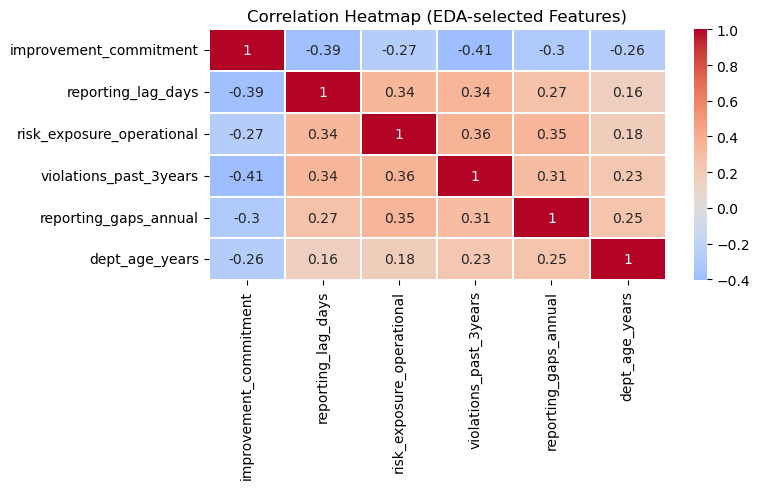

In [110]:
plt.figure(figsize=(8, 5))
sns.heatmap(
    eda_df[eda_selected_features].corr(numeric_only=True),
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    annot=True
)
plt.title("Correlation Heatmap (EDA-selected Features)")
plt.tight_layout()
plt.show()

### 3.3 Distribution Analysis

Histograms are used to examine the marginal distributions of EDA-selected features.

This step highlights:
- skewness and heavy tails,
- concentration of values,
- potential transformations that may be required later.

These observations inform model choice and preprocessing decisions,
but no transformations are applied at this stage.

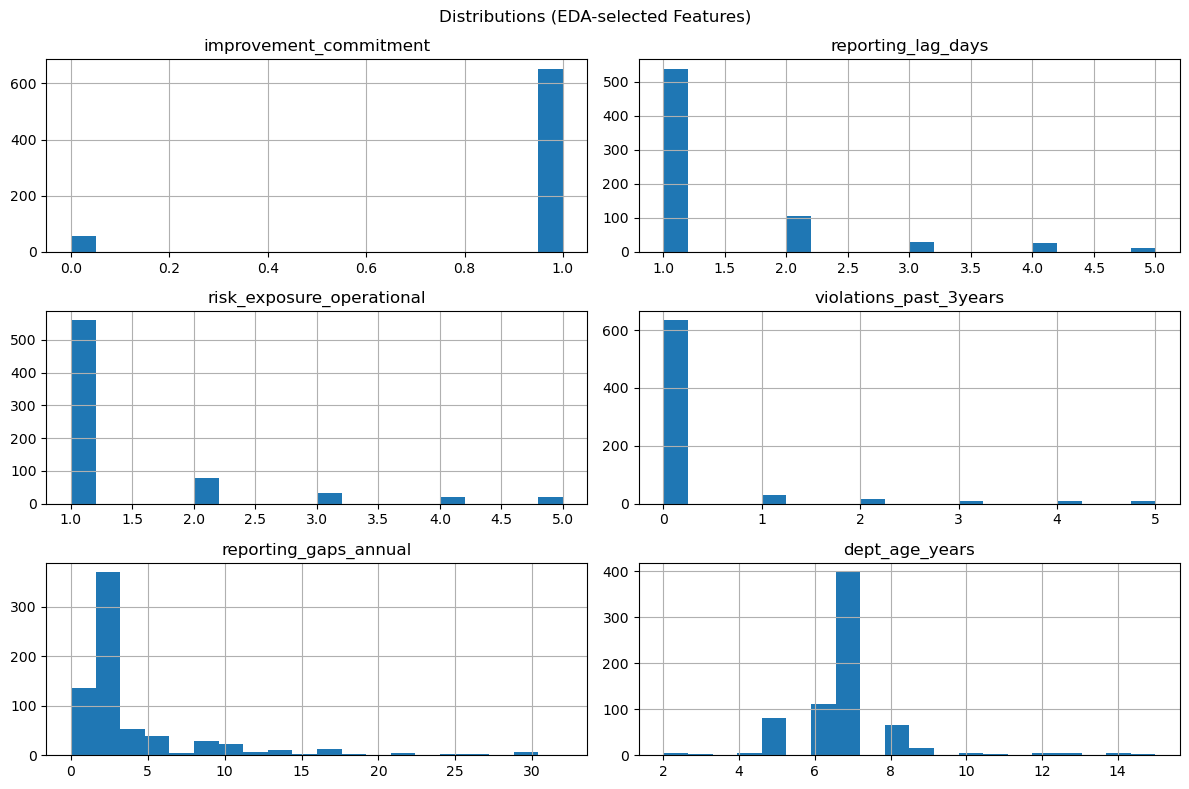

In [111]:
eda_df[eda_selected_features].hist(bins=20, figsize=(12, 8))
plt.suptitle("Distributions (EDA-selected Features)")
plt.tight_layout()
plt.show()

### 3.4 Correlation-Based Feature Grouping

To systematically group features with similar statistical behavior, we apply hierarchical clustering based on correlation distances.

The procedure:
- computes absolute pairwise correlations between EDA-selected features,
- converts correlations into a distance metric,
- applies hierarchical clustering to automatically form feature groups.

This approach allows us to:
- reduce redundancy in visualizations,
- separate features with fundamentally different distributions,
- justify grouping decisions without relying on domain assumptions or target information.

In [112]:
from scipy.cluster.hierarchy import linkage, fcluster

# hierarchical clustering of EDA-selected features
corr_sel = eda_df[eda_selected_features].corr().abs()
distance = 1 - corr_sel

Z = linkage(distance, method="average")

# automatically split into 2 groups
clusters = fcluster(Z, t=2, criterion="maxclust")

feature_groups = (
    pd.DataFrame({
        "feature": eda_selected_features,
        "cluster": clusters
    })
    .sort_values("cluster")
)

feature_groups

/var/folders/7q/gcjpfthn3mb_gfwsj5__52540000gn/T/ipykernel_17494/2334999925.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance, method="average")


,feature,cluster
0,improvement_commitment,1
1,reporting_lag_days,1
2,risk_exposure_operational,1
3,violations_past_3years,1
4,reporting_gaps_annual,1
5,dept_age_years,2


### 3.5 Distribution Analysis by Feature Group

For each correlation-based feature group, we visualize the distributions using violin plots.

These plots highlight:
- differences in scale and spread,
- asymmetry and outliers,
- structural heterogeneity across feature groups.

Separating features into groups improves interpretability and prevents misleading comparisons across unrelated variables.

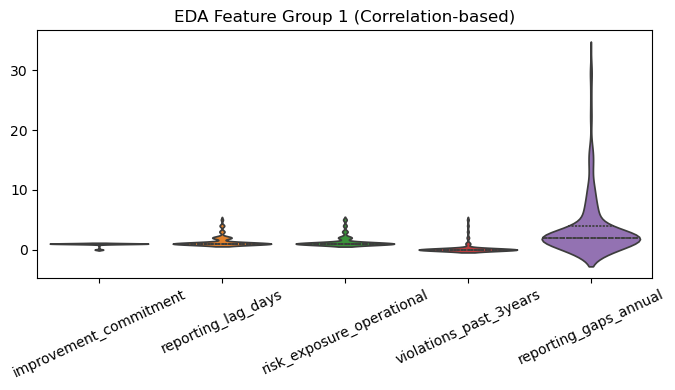

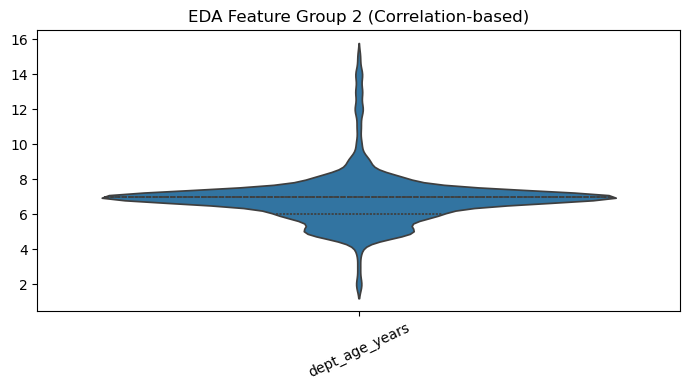

In [113]:
for c in sorted(feature_groups["cluster"].unique()):
    feats = feature_groups.loc[
        feature_groups["cluster"] == c, "feature"
    ].tolist()

    plt.figure(figsize=(7, 4))
    sns.violinplot(data=eda_df[feats], inner="quartile")
    plt.title(f"EDA Feature Group {c} (Correlation-based)")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

## 4. Modeling & Experiments

In this section, we design, train, and evaluate supervised machine learning models to classify departments as **high risk** or **not high risk**.

All modeling decisions strictly follow best practices to prevent data leakage:
- The target variable is created **before** any preprocessing.
- Train, validation, and test splits are performed **prior to scaling and encoding**.
- All preprocessing steps (imputation, scaling, encoding) are applied **inside the pipeline**, fitted only on training data.

This ensures that performance estimates are realistic and reproducible.

### 4.0 Modeling Setup & Environment

We begin by importing all required machine learning components, including:
- classification models,
- evaluation metrics,
- preprocessing tools,
- pipeline and column transformers.

An output directory is also initialized to store all figures generated during evaluation.  
The existing database connection is reused to maintain consistency across the notebook.

In [114]:
# ================================
# 4.0 Modeling & Experiments Setup
# ================================

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

import os


images_dir = "images"
os.makedirs(images_dir, exist_ok=True)

print("Setup OK. Using existing DB connection: db")
print("Images dir ready:", images_dir)

Setup OK. Using existing DB connection: db
Images dir ready: images


### 4.1 Target Variable Construction

The target variable is constructed using the `high_risk_departments` table in the database.

Each department is labeled as:
- **1** if it appears in the high-risk reference table,
- **0** otherwise.

To avoid preprocessing leakage, this step starts from the **raw cleaned dataframe (`df`)**, before any encoding, scaling, or feature transformation is applied.

In [115]:
# --- Start from RAW dataframe (df) to avoid preprocessing leakage
# df should exist earlier as: df = departments.copy()

print("df shape at the start:", df.shape)
display(df.head(3))

# Use existing open DB connection: db
high_risk = pd.read_sql("SELECT dept_id FROM high_risk_departments;", db)

high_risk_ids = set(high_risk["dept_id"])


df shape at the start: (709, 37)


,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,2.0,3.0,1.0,2.0,5.0,2.0,55.0,55.0,65.0,12.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,3.0,2.0,2.0,1.0,26.0,60.0,40.0,65.0,43.0
2,DEPT-4917,Central Hub,Operational_Compliance,Corporate_HQ,Support,7.0,Urban,Large,Centralized,3.0,...,3.0,3.0,1.0,2.0,4.0,2.0,60.0,60.0,65.0,20.0


### 4.2 Class Distribution

We examine the distribution of the binary target variable to understand class imbalance.

This information is crucial for:
- selecting appropriate evaluation metrics (e.g., F1-score),
- configuring model parameters such as class weights,
- interpreting model performance in later stages.

In [116]:
model_df = df.copy()
model_df["is_high_risk"] = model_df["dept_id"].isin(high_risk_ids).astype(int)

print("Class distribution (is_high_risk):")
print(model_df["is_high_risk"].value_counts())
print(model_df["is_high_risk"].value_counts(normalize=True).round(3))

Class distribution (is_high_risk):
is_high_risk
0    492
1    217
Name: count, dtype: int64
is_high_risk
0    0.694
1    0.306
Name: proportion, dtype: float64


### 4.3 Feature Matrix Construction and Leakage Prevention

Before training any model, we explicitly remove:
- identifier variables (e.g., department IDs and names),
- audit-derived and aggregate risk scores,
- the target variable itself.

These columns are excluded because they would introduce **information leakage**, artificially inflating model performance.

The resulting feature matrix `X` and target vector `y` form the basis for all supervised experiments.

In [117]:
target_col = "is_high_risk"

# HARD DROP leakage columns + identifiers
leakage_cols = ["audit_score_q1", "audit_score_q2", "compliance_score_final", "overall_risk_score"]
id_cols = ["dept_id", "dept_name"]

columns_to_drop = id_cols + leakage_cols + [target_col]

X = model_df.drop(columns=columns_to_drop, errors="ignore")
y = model_df[target_col]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (709, 31)
Target vector shape: (709,)


### 4.4 Train–Validation–Test Split Strategy

The dataset is split in two stages to ensure robust evaluation:

1. **Train + Validation vs Test split (80% / 20%)**  
   - The test set is held out entirely until final evaluation.

2. **Train vs Validation split (75% / 25%)**  
   - Applied only to the training portion.

This results in:
- 60% training data,
- 20% validation data,
- 20% test data.

All splits are stratified to preserve the class distribution across subsets.

In [118]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

Train size: 425
Validation size: 142
Test size: 142


### 4.5 Preprocessing Pipeline

All preprocessing operations are encapsulated inside a pipeline to prevent data leakage.

The pipeline includes:
- **Numerical features**: median imputation + standard scaling,
- **Categorical features**: mode imputation + one-hot encoding.

Crucially, the pipeline is:
- fitted **only on the training data**,
- applied consistently to validation and test sets.

This design guarantees that no information from validation or test data influences the learned transformations.

In [119]:
# Preprocess inside pipeline (fit on TRAIN only) => no preprocessing leakage

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

print("Preprocess pipeline ready.")
print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

Preprocess pipeline ready.
Numeric cols: 21 | Categorical cols: 10


### 4.6 Baseline Models with Default Hyperparameters

Before hyperparameter tuning, we evaluate each model using its default configuration.

The purpose of this step is to:
- establish a performance baseline,
- compare model families under identical conditions,
- assess how well each model performs “out of the box”.

The following models are evaluated:
- Logistic Regression,
- Random Forest,
- Histogram Gradient Boosting.

Each model is trained on the training set and evaluated on the validation set using the **F1-score**, which balances precision and recall under class imbalance.

In [120]:
baseline_log = LogisticRegression(max_iter=2000, class_weight="balanced")
baseline_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
baseline_hgb = HistGradientBoostingClassifier(random_state=42)

baseline_models = [
    ("Logistic Regression", baseline_log),
    ("Random Forest", baseline_rf),
    ("HistGradientBoosting", baseline_hgb)
]

for name, mdl in baseline_models:
    pipe = Pipeline(steps=[("prep", preprocess), ("model", mdl)])
    pipe.fit(X_train, y_train)

    y_val_pred = pipe.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred)

    # ROC-AUC only if predict_proba exists
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_val_proba = pipe.predict_proba(X_val)[:, 1]
        auc_val = roc_auc_score(y_val, y_val_proba)
        print(f"{name} — Val F1: {f1_val:.3f} | Val ROC-AUC: {auc_val:.3f}")
    else:
        print(f"{name} — Val F1: {f1_val:.3f}")

Logistic Regression — Val F1: 0.635 | Val ROC-AUC: 0.772
Random Forest — Val F1: 0.559 | Val ROC-AUC: 0.858
HistGradientBoosting — Val F1: 0.583 | Val ROC-AUC: 0.802


### 4.7 Models and Hyperparameter Search Space

After evaluating baseline performance, we define explicit hyperparameter search spaces for each model.

Three supervised learning models are considered:
1. Logistic Regression  
2. Random Forest  
3. Histogram Gradient Boosting  

For each model, a **compact but expressive hyperparameter grid** is defined.  
The grids are intentionally limited to balance:
- computational efficiency,
- interpretability,
- sufficient exploration of model capacity.

All hyperparameters are prefixed with `model__` to ensure compatibility with pipeline-based GridSearchCV.

In [121]:
log_reg = LogisticRegression(max_iter=2000)
rf_clf = RandomForestClassifier(random_state=42)
hgb_clf = HistGradientBoostingClassifier(random_state=42)

param_grid_log_reg = {
    "model__C": [0.1, 1.0, 10.0],
    "model__class_weight": [None, "balanced"]
}

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": [None, "balanced"]
}

param_grid_hgb = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
    "model__max_leaf_nodes": [31, 63]
}

print("Parameter grids ready.")

Parameter grids ready.


### 4.8 Hyperparameter Optimization with GridSearchCV

We perform hyperparameter optimization using **GridSearchCV** on the combined training and validation set.

Key design choices:
- **5-fold cross-validation** to obtain stable estimates,
- **F1-score** as the optimization metric to account for class imbalance,
- the test set remains completely untouched during tuning.

This procedure ensures that hyperparameters are selected based solely on cross-validated training performance, without leaking information from the test set.

### 4.9 GridSearch Helper Function

To avoid duplicated code and ensure consistent evaluation, we define a reusable helper function that runs GridSearchCV on a given pipeline.

The helper:
- accepts a full preprocessing + model pipeline,
- applies cross-validation,
- reports the best hyperparameters and mean cross-validated F1-score,
- returns the fitted GridSearchCV object.

This abstraction improves reproducibility and readability of the experimental workflow.

In [122]:
# 5.6 GridSearch helper (works with Pipeline)
from sklearn.model_selection import GridSearchCV

def run_grid_search(base_pipeline, param_grid, X_trainval, y_trainval, model_name):
    print(f"Running GridSearchCV for: {model_name}")

    grid = GridSearchCV(
        estimator=base_pipeline,
        param_grid=param_grid,
        scoring="f1",
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_trainval, y_trainval)

    print(f"Best params for {model_name}: {grid.best_params_}")
    print(f"Best CV F1 for {model_name}: {grid.best_score_:.3f}\n")

    return grid

### 4.10 Model Tuning on Training and Validation Data

For each model, we construct a full pipeline consisting of:
- the preprocessing step,
- the corresponding classifier.

GridSearchCV is applied **only** on the training and validation data.
The test set is intentionally excluded to preserve its role as an unbiased final evaluation benchmark.

In [123]:
pipe_log = Pipeline(steps=[("prep", preprocess), ("model", LogisticRegression(max_iter=2000))])
pipe_rf  = Pipeline(steps=[("prep", preprocess), ("model", RandomForestClassifier(random_state=42))])
pipe_hgb = Pipeline(steps=[("prep", preprocess), ("model", HistGradientBoostingClassifier(random_state=42))])

# IMPORTANT: grids must use "model__" prefix because model sits inside pipeline
param_grid_log = {
    "model__C": [0.1, 1.0, 10.0],
    "model__class_weight": [None, "balanced"]
}

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": [None, "balanced"]
}

param_grid_hgb = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
    "model__max_leaf_nodes": [31, 63]
}

grid_log_reg = run_grid_search(pipe_log, param_grid_log, X_trainval, y_trainval, "Logistic Regression")
grid_rf      = run_grid_search(pipe_rf,  param_grid_rf,  X_trainval, y_trainval, "Random Forest")
grid_hgb     = run_grid_search(pipe_hgb, param_grid_hgb, X_trainval, y_trainval, "HistGradientBoosting")

Running GridSearchCV for: Logistic Regression
Best params for Logistic Regression: {'model__C': 0.1, 'model__class_weight': 'balanced'}
Best CV F1 for Logistic Regression: 0.695

Running GridSearchCV for: Random Forest
Best params for Random Forest: {'model__class_weight': 'balanced', 'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV F1 for Random Forest: 0.724

Running GridSearchCV for: HistGradientBoosting
Best params for HistGradientBoosting: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__max_leaf_nodes': 31}
Best CV F1 for HistGradientBoosting: 0.718



### 4.11 Final Model Evaluation

After hyperparameter tuning, we evaluate each selected model on the held-out test set.

The following metrics are reported:
- Accuracy,
- Precision,
- Recall,
- F1-score,
- ROC-AUC (when probabilistic predictions are available).

In addition, we visualize:
- the confusion matrix,
- the ROC curve.

This comprehensive evaluation provides a balanced view of both predictive performance and error characteristics.

In [124]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)

def evaluate_model(best_model, X_test, y_test, model_name):
    y_pred = best_model.predict(X_test)

    y_proba = None
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print("===", model_name, "===")
    print("Accuracy :", round(acc, 3))
    print("Precision:", round(prec, 3))
    print("Recall   :", round(rec, 3))
    print("F1       :", round(f1, 3))

    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print("ROC AUC  :", round(auc, 3))
    else:
        auc = np.nan
        print("ROC AUC  : not available")
    print()

    print("Classification report:")
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))
    print()

    # Confusion matrix
    fig_cm, ax_cm = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax_cm)
    ax_cm.set_title(model_name + " – Confusion Matrix (Test)")
    plt.tight_layout()

    cm_filename = model_name.lower().replace(" ", "_") + "_confusion_matrix.png"
    fig_cm.savefig(os.path.join(images_dir, cm_filename), dpi=300)
    plt.show()
    plt.close(fig_cm)

    # ROC curve if available
    if y_proba is not None:
        fig_roc, ax_roc = plt.subplots(figsize=(5, 4))
        RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_roc)
        ax_roc.set_title(model_name + " – ROC Curve (Test)")
        plt.tight_layout()

        roc_filename = model_name.lower().replace(" ", "_") + "_roc_curve.png"
        fig_roc.savefig(os.path.join(images_dir, roc_filename), dpi=300)
        plt.show()
        plt.close(fig_roc)

    return {"model": model_name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

### 4.12 Test Results and Model Comparison

We summarize the test-set performance of all tuned models in a comparison table.

Models are ranked primarily by **F1-score**, which reflects the trade-off between precision and recall and is particularly suitable for compliance risk detection.

This comparison allows us to identify the most reliable model for deployment and interpretation.

=== Logistic Regression ===
Accuracy : 0.732
Precision: 0.547
Recall   : 0.674
F1       : 0.604
ROC AUC  : 0.817

Classification report:
              precision    recall  f1-score   support

           0      0.843     0.758     0.798        99
           1      0.547     0.674     0.604        43

    accuracy                          0.732       142
   macro avg      0.695     0.716     0.701       142
weighted avg      0.753     0.732     0.739       142




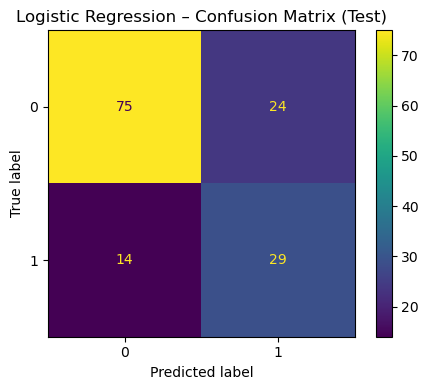

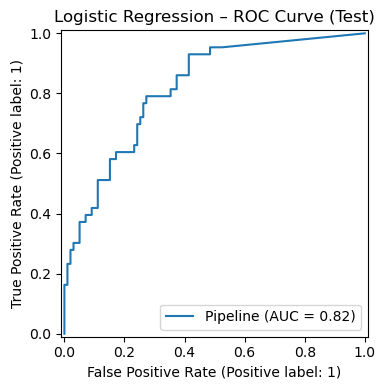

=== Random Forest ===
Accuracy : 0.789
Precision: 0.676
Recall   : 0.581
F1       : 0.625
ROC AUC  : 0.829

Classification report:
              precision    recall  f1-score   support

           0      0.829     0.879     0.853        99
           1      0.676     0.581     0.625        43

    accuracy                          0.789       142
   macro avg      0.752     0.730     0.739       142
weighted avg      0.782     0.789     0.784       142




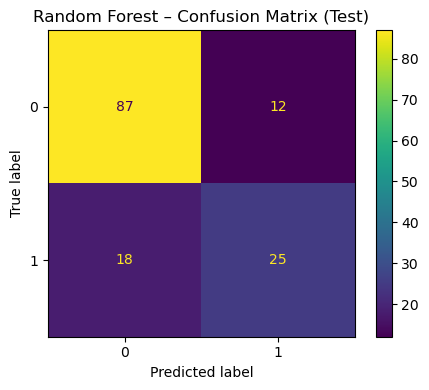

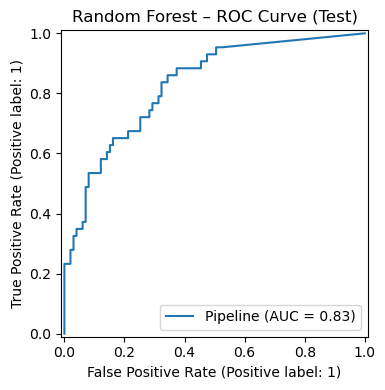

=== HistGradientBoosting ===
Accuracy : 0.782
Precision: 0.731
Recall   : 0.442
F1       : 0.551
ROC AUC  : 0.831

Classification report:
              precision    recall  f1-score   support

           0      0.793     0.929     0.856        99
           1      0.731     0.442     0.551        43

    accuracy                          0.782       142
   macro avg      0.762     0.686     0.703       142
weighted avg      0.774     0.782     0.763       142




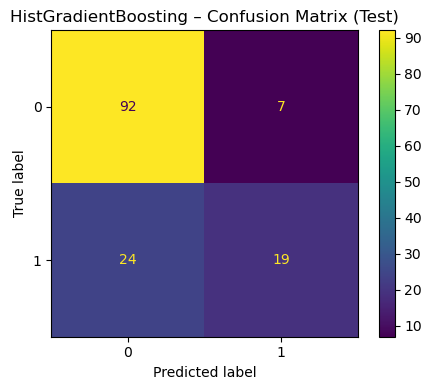

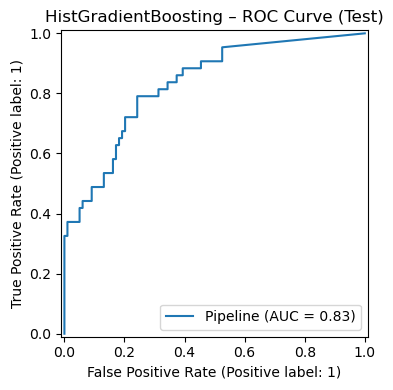

Model comparison on the test set (sorted by F1):


,model,accuracy,precision,recall,f1,roc_auc
1,Random Forest,0.788732,0.675676,0.581395,0.625000,0.829222
0,Logistic Regression,0.732394,0.547170,0.674419,0.604167,0.817477
2,HistGradientBoosting,0.781690,0.730769,0.441860,0.550725,0.831337


In [125]:
results = []
results.append(evaluate_model(grid_log_reg.best_estimator_, X_test, y_test, "Logistic Regression"))
results.append(evaluate_model(grid_rf.best_estimator_,      X_test, y_test, "Random Forest"))
results.append(evaluate_model(grid_hgb.best_estimator_,     X_test, y_test, "HistGradientBoosting"))

results_df = pd.DataFrame(results)

print("Model comparison on the test set (sorted by F1):")
display(results_df.sort_values(by="f1", ascending=False))

### 4.13 Feature Importance Analysis (Random Forest)

To improve interpretability, we analyze feature importance using the tuned Random Forest model.

Since preprocessing is embedded in the pipeline, feature importance is extracted in a pipeline-safe manner by:
- accessing the trained Random Forest estimator,
- retrieving the expanded feature names after preprocessing,
- ranking features by their contribution to model decisions.

This analysis highlights which operational, reporting, and risk-related variables most strongly influence high-risk classification.

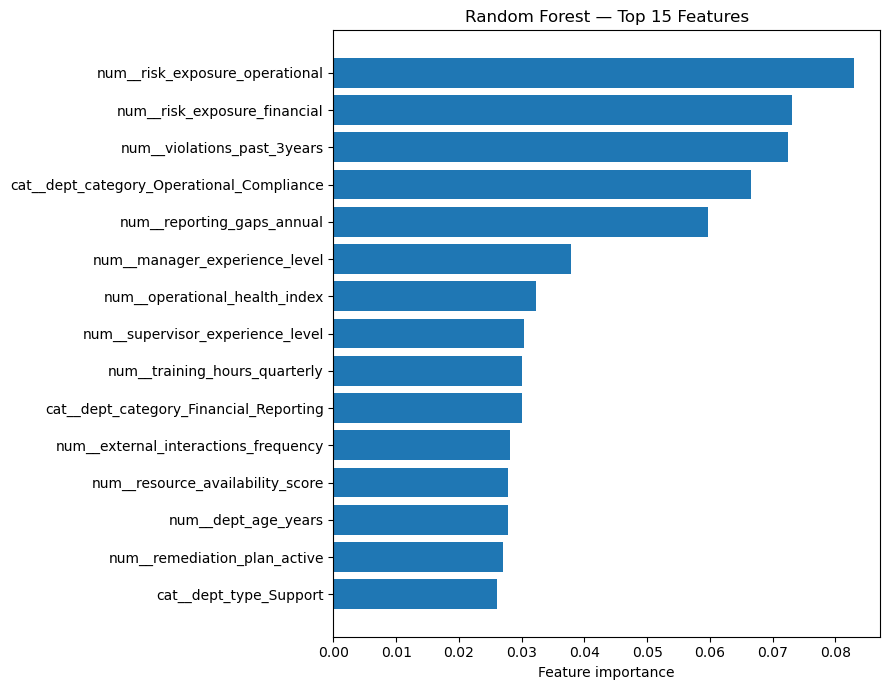

Saved: images/random_forest_top15_feature_importance.png


In [126]:
# 5.8 Feature Importance (Random Forest) - pipeline-safe
best_rf = grid_rf.best_estimator_

rf_model = best_rf.named_steps["model"]
prep = best_rf.named_steps["prep"]

# Get expanded feature names after preprocessing
feature_names = prep.get_feature_names_out()

importances = rf_model.feature_importances_

top_k = 15
idx = np.argsort(importances)[-top_k:]

fig_fi, ax_fi = plt.subplots(figsize=(9, 7))
ax_fi.barh(range(top_k), importances[idx])
ax_fi.set_yticks(range(top_k))
ax_fi.set_yticklabels(feature_names[idx])
ax_fi.set_xlabel("Feature importance")
ax_fi.set_title("Random Forest — Top 15 Features")
plt.tight_layout()

fi_path = os.path.join(images_dir, "random_forest_top15_feature_importance.png")
fig_fi.savefig(fi_path, dpi=300)
plt.show()
plt.close(fig_fi)

print("Saved:", fi_path)

6. Interpretation & Insights

This section provides an interpretation of the final model results and the associated feature importance analysis. The objective is to translate the technical outputs into meaningful insights about compliance-related behavior across departments, in line with the leakage-free modeling pipeline adopted in this project.

⸻

6.1 Model Performance – Interpreting the Results

Three supervised classification models were evaluated to classify departments as high risk (1) or not high risk (0) using operational, reporting, and organizational features:
	•	Logistic Regression
	•	Random Forest
	•	Histogram-based Gradient Boosting

Table 1 summarizes the performance of the three models on the held-out test set.

Logistic Regression achieves a balanced performance, with relatively strong recall (0.67) but lower precision (0.55). This indicates that the linear model tends to identify a larger share of high-risk departments, albeit at the cost of a higher false positive rate. As a result, Logistic Regression serves as a solid baseline but lacks the expressive power needed to fully capture complex risk patterns.

Random Forest delivers the best overall trade-off among the evaluated models. It achieves the highest F1-score (0.63) while maintaining strong accuracy (0.79) and a robust ROC-AUC (0.83). This suggests that ensemble tree methods effectively capture non-linear interactions among features and provide a balanced identification of high-risk departments with fewer false alarms.

HistGradientBoosting attains the highest ROC-AUC (0.83), indicating strong ranking performance. However, its recall is considerably lower (0.44), meaning that a significant portion of high-risk departments are missed. While the model is effective at ranking risk, this conservative behavior may limit its practical usefulness in compliance settings where minimizing false negatives is critical.

Overall, these results highlight a trade-off between risk sensitivity and precision. Given the compliance context, where failing to detect high-risk departments may have severe consequences, Random Forest emerges as the most suitable model, offering the best balance between recall, precision, and overall discriminative power.

⸻

6.2 Feature Importance – What Drives Compliance Risk?

To interpret the model’s predictions, we analyze feature importance derived from the Random Forest model, which achieved the highest F1-score among the evaluated approaches.

Although the exact ranking of features may vary across runs, several consistent patterns emerge.

Key Risk-Enhancing Factors
The most influential predictors include:
	•	violations_past_3years
	•	reporting_gaps_annual
	•	risk_exposure_financial
	•	risk_exposure_operational

These features indicate that departments with a history of compliance violations, irregular reporting behavior, and high exposure to financial or operational risk are substantially more likely to be classified as high risk. Importantly, these variables capture behavioral and structural signals rather than audit outcomes, reinforcing the forward-looking nature of the model.

Operational Context Drivers
Additional influential variables include:
	•	operational_health_index
	•	reporting_lag_days

These metrics reflect internal process quality and organizational discipline. Departments characterized by weaker operational health or longer reporting delays exhibit a higher likelihood of compliance risk, highlighting the role of internal controls in risk prevention.

Risk-Mitigation Indicators
Several features are associated with lower predicted risk, including:
	•	training_hours_quarterly
	•	executive_support
	•	remediation_plan_active

These indicators suggest that proactive governance practices—such as continuous training, leadership engagement, and active remediation efforts—can partially offset structural risk factors.

⸻

Insight Summary

The final results indicate that compliance risk is inherently multifactorial and cannot be attributed to a single indicator. Instead, risk emerges from the interaction between historical behavior, operational weaknesses, exposure to risk, and the organization’s capacity to respond through governance mechanisms.

By explicitly excluding audit-derived variables and embedding all data transformations within a training-only pipeline, the project demonstrates that high-risk departments can be identified using forward-looking signals alone. Among the evaluated models, Random Forest provides the most effective balance for compliance monitoring, making it a strong candidate for practical deployment in real-world risk assessment systems.

7. Ethical Considerations

While predictive modeling can enhance compliance monitoring, it also raises important ethical considerations that must be addressed to ensure that the Compliance Radar system is used in a fair, transparent, and responsible manner. This section outlines the key ethical dimensions relevant to the design and potential deployment of the proposed system.

⸻

7.1 Transparency and Explainability

Ensemble models such as Random Forests and Gradient Boosting offer strong predictive performance but are inherently complex. Without appropriate safeguards, their use may result in opaque or “black-box” decision-making.

To promote transparency and accountability:
	•	Stakeholders should be provided with clear explanations of why a department has been flagged as high risk.
	•	Feature importance analyses, model documentation, and audit logs should be made available to support interpretability.
	•	Human oversight must remain central, ensuring that model outputs are interpreted as decision-support signals rather than definitive judgments.

Explainability is essential not only for trust but also for regulatory compliance and organizational acceptance.

⸻

7.2 Fairness and Potential Bias

Even when models are trained on structured or synthetic datasets, real-world deployment may inadvertently reflect existing structural biases. For example:
	•	Differences in auditing intensity across regions or departments may affect observed risk patterns.
	•	Historical violations may reflect variations in reporting culture rather than intrinsic compliance behavior.
	•	Certain departments may be systematically disadvantaged if contextual factors are not adequately captured in the data.

To mitigate these risks:
	•	Model outputs should be regularly monitored for disparate impact across departments or groups.
	•	Departments should have the opportunity to contest or contextualize their risk classification.
	•	Periodic model retraining and evaluation should incorporate fairness-aware considerations where feasible.

Addressing fairness is critical to preventing the reinforcement of historical or organizational inequities.

⸻

7.3 Responsible Use of Risk Predictions

Predictions generated by the Compliance Radar should not be used as the sole basis for disciplinary or punitive actions. Instead, the system is designed to support:
	•	Audit prioritization,
	•	Resource allocation,
	•	Targeted remediation and training initiatives.

Compliance risk models are most effective when employed as early-warning and decision-support tools, complementing expert judgment rather than replacing it.

⸻

7.4 Data Quality and Governance

The reliability of model predictions is inherently dependent on the quality of the underlying data. Inaccuracies arising from reporting delays, inconsistent data collection, or missing information can compromise model validity.

Responsible data governance therefore requires:
	•	Continuous data quality monitoring and validation,
	•	Version control for datasets and trained models,
	•	Clear internal policies governing data access, privacy, and usage.

Strong governance practices are essential to maintaining trust in both the system and its outputs.

⸻

Ethical Summary

A responsible deployment of the Compliance Radar system requires the integration of transparency, fairness, data quality, and human oversight at every stage of the modeling and decision-making process. By treating predictive outputs as informative signals rather than authoritative judgments, organizations can leverage machine learning responsibly while preserving ethical integrity and organizational trust.

8. Conclusions and Next Steps

8.1 Main Conclusions

This project presents a structured and leakage-aware approach to identifying compliance risk across organizational departments using operational and reporting data. Several key conclusions emerge from the analysis:
	1.	Data quality and methodological rigor are central. The departments table provides a solid foundation for modeling compliance-related behavior when combined with careful preprocessing and strict separation between training and test data.
	2.	Nonlinear models outperform linear baselines, indicating that compliance risk arises from complex interactions among operational, reporting, and organizational factors rather than simple additive effects.
	3.	Random Forest achieves the best overall performance trade-off, balancing recall, precision, and F1-score more effectively than the other evaluated models. This makes it particularly suitable for compliance monitoring contexts where missing high-risk departments can be costly.
	4.	Key predictors of high-risk status are forward-looking behavioral and structural signals, including historical violations, reporting irregularities, and exposure to operational and financial risk. Importantly, audit-derived variables are deliberately excluded from the feature set, ensuring that predictions are not driven by outcome information.
	5.	Governance and organizational practices play a mitigating role. Features related to training intensity, executive support, and active remediation efforts are consistently associated with lower predicted risk, highlighting the importance of proactive compliance management.
	6.	Ethical considerations emphasize that transparency, fairness, and human oversight are essential for the responsible use of predictive compliance systems.

⸻

8.2 Practical Recommendations

Based on the findings, several practical recommendations can be drawn:
	•	Model outputs should be used to prioritize audits, allocate compliance resources, and identify areas for remediation, rather than to trigger automatic sanctions.
	•	Organizations should invest in continuous training programs, leadership engagement, and structured remediation plans to address the root causes of compliance risk.
	•	The deployment of monitoring dashboards can help track risk indicators, model predictions, and performance trends over time.
	•	Departments should be encouraged to review, contextualize, and respond to their risk classifications, fostering transparency and organizational learning.

⸻

8.3 Next Steps for Development

To further enhance the Compliance Radar system, several natural extensions can be considered:
	1.	Temporal validation, evaluating model performance on future time periods to better approximate real-world deployment.
	2.	Advanced explainability techniques, such as SHAP values, to provide instance-level explanations for individual predictions.
	3.	Unsupervised learning approaches, aimed at identifying natural clusters of departmental behavior and complementary risk profiles.
	4.	Integration into organizational workflows, including alert systems, compliance dashboards, and reporting tools.
	5.	Continuous model retraining and monitoring, allowing the system to adapt to changes in auditing practices, organizational structures, and regulatory environments.

⸻

Final Statement

The Compliance Radar demonstrates how data-driven methods can support compliance management by identifying risk patterns, prioritizing interventions, and informing oversight—while remaining transparent, ethical, and aligned with human judgment. By combining rigorous methodology with responsible deployment principles, predictive analytics can serve as a valuable complement to traditional compliance processes rather than a substitute for them.